# Read Datafile

In [ ]:
import pandas as pd
import math
import gzip
import csv
import sys

In [ ]:
duolingo_data = pd.read_csv(r'C:\Users\Alexander\Dropbox\halflife_regression_rl\0_data/learning_traces.13m.csv')

In [ ]:
# Constants
MIN_HALF_LIFE = 15.0 / (24 * 60)  # 15 minutes
MAX_HALF_LIFE = 274.0             # 9 months
LN2 = math.log(2)

def pclip(p):
    return min(max(p, 0.0001), 0.9999)

def hclip(h):
    return min(max(h, MIN_HALF_LIFE), MAX_HALF_LIFE)

# Convert time delta to days and calculate half-life
duolingo_data['p_recall'] = duolingo_data['p_recall'].apply(pclip)
duolingo_data['t'] = duolingo_data['delta'] / (60 * 60 * 24)
duolingo_data['h'] = duolingo_data.apply(lambda row: hclip(-row['t'] / (math.log(row['p_recall'], 2) if row['p_recall'] > 0 else float('inf'))), axis=1)
duolingo_data['lang'] = duolingo_data['ui_language'] + "->" + duolingo_data['learning_language']
# Feature vector creation based on method

duolingo_data['seen'] = duolingo_data['history_seen']
duolingo_data['right'] = duolingo_data['history_correct']
duolingo_data['wrong'] = duolingo_data['history_seen'] - duolingo_data['right']

duolingo_data['right_this'] = duolingo_data['session_correct']
duolingo_data['wrong_this'] = duolingo_data['session_seen']

duolingo_data['right'] = duolingo_data['right'].apply(lambda x: math.sqrt(1+x))
duolingo_data['wrong'] = (duolingo_data['wrong']).apply(lambda x: math.sqrt(1+x))

duolingo_data['a'] = (duolingo_data['right'] + 2) / (duolingo_data['seen'] + 4)

duolingo_data['lexeme'] = duolingo_data['learning_language'] + ":" + duolingo_data['lexeme_string']

duolingo_data['time'] = duolingo_data['t']

In [ ]:
duolingo_data

In [ ]:
en_duolingo = duolingo_data[duolingo_data['learning_language'] == 'en']
en_duolingo

In [ ]:
en_duolingo['datetime'] = pd.to_datetime(en_duolingo['timestamp'], unit='s')
en_duolingo['datetime']

In [ ]:
# Function to convert time to decimal hours
def time_to_decimal(time):
    return time.hour + time.minute / 60 + time.second / 3600

# Apply the function to the 'datetime' column
en_duolingo['decimal_hours'] = en_duolingo['datetime'].apply(lambda x: time_to_decimal(x))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(en_duolingo['decimal_hours'], bins=50, color='skyblue', edgecolor='black', stat='percent')

plt.title('Histogram of Decimal Hours', fontsize=15)
plt.xlabel('Time Session', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.savefig('C:/Users/Alexander/Documents/GitHub/NNLangRecall/figs/decimal_hours_histogram.jpg', format='jpg')  # Save as JPG
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(en_duolingo['p_recall'], bins=50, color='skyblue', edgecolor='black', stat='percent')

plt.title('Probability of Recall Distribution', fontsize=15)
plt.xlabel('Probability of Recall', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting the histogram
# plt.figure(figsize=(10, 6))  # Set the size of the figure
# plt.hist(en_duolingo['p_recall'], bins=30, color='skyblue', edgecolor='black', stat='percent')
# a
# # Adding titles and labels
# plt.title('Probability of Recall Distribution', fontsize=15)
# plt.xlabel('Probability of Recall', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)

# # Optional: Adding a grid for easier readability
# plt.grid(axis='y', alpha=0.75)

# plt.show()


In [ ]:
def plot_histogram(data, column, bins=30, title=None, xlabel=None):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=bins, color='skyblue', edgecolor='black')
    plt.title(title or f'Histogram of {column}', fontsize=15)
    plt.xlabel(xlabel or column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_histograms(dataframe, columns_info, rows, cols,  filename):
    """
    Plots histograms in a grid layout for the specified columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data.
    :param columns_info: List of dictionaries with keys 'column', 'bins', 'title', 'xlabel'.
    :param rows: Number of rows in the grid.
    :param cols: Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))
    axes = axes.ravel()  # Flatten the array of axes

    for i, info in enumerate(columns_info):
        # Calculate the percentages for the histogram
        counts, bins = np.histogram(dataframe[info['column']], bins=info.get('bins', 10))
        percentages = counts / counts.sum() * 100

        # Plotting
        sns.histplot(dataframe, x=info['column'], bins=bins, ax=axes[i], stat='percent')
        axes[i].set_title(info['title'])
        axes[i].set_xlabel(info['xlabel'])
        axes[i].set_ylabel('Percentage')


    plt.tight_layout()
    plt.savefig(filename, format=filename.split('.')[-1])
    plt.close(fig)



# Usage
columns_info = [
    {'column': 'p_recall', 'title': 'Probability of Recall Distribution', 'xlabel': 'Probability'},
    {'column': 'h', 'bins': 40, 'title': 'Half-life Measure Distribution', 'xlabel': 'Half-life (Days)'},
    {'column': 't', 'bins': 40, 'title': 'Lag Time in Days Distribution', 'xlabel': 'Days'},
    {'column': 'seen', 'bins': 40, 'title': 'Total number of exposures to a word', 'xlabel': 'Seen Count'},
    {'column': 'right', 'bins': 40, 'title': 'Correct recalls Distribution', 'xlabel': 'Right Count'},
    {'column': 'wrong', 'bins': 40, 'title': 'Incorrect recalls Distribution', 'xlabel': 'Wrong Count'}
]

plot_histograms(duolingo_data, columns_info, rows=3, cols=2,  filename='C:/Users/Alexander/Documents/GitHub/NNLangRecall/figs/duolingo_histograms.jpg')


In [ ]:
plot_histogram(duolingo_data, 'p_recall', title='Probability of Recall Distribution', xlabel='Probability of Recall')

plot_histogram(duolingo_data, 'h', bins=40, title='Half-life Distribution', xlabel='Half-life (Days)')

plot_histogram(duolingo_data, 't', bins=40, title='Time Delta in Days Distribution', xlabel='Days')

# Similarly, for other variables like 'seen', 'right', 'wrong', 'a'
plot_histogram(duolingo_data, 'seen', bins=40, title='Seen Distribution', xlabel='Seen Count')

plot_histogram(duolingo_data, 'right', bins=40, title='Right Distribution', xlabel='Right Count')

plot_histogram(duolingo_data, 'wrong', bins=40, title='Wrong Distribution', xlabel='Wrong Count')
plot_histogram(duolingo_data, 'decimal_hours', bins=40, title='Session Time', xlabel='Wrong Count')


#plot_histogram(duolingo_data, 'a', bins=40, title='Feature A Distribution', xlabel='Feature A')


In [ ]:
en_duolingo['datetime']

In [ ]:
import pandas as pd

# Assuming en_duolingo['datetime'] is a string representing datetime
en_duolingo['date_only'] = pd.to_datetime(en_duolingo['datetime']).dt.date
en_duolingo['date_only']

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(en_duolingo['date_only'], bins=30, kde=False, color='skyblue')
plt.title('Practice Dates Distribution', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Frequency of Practice', fontsize=12)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()


In [ ]:
user_trials = duolingo_data.groupby('user_id').size().reset_index(name='trial_count')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(user_trials['trial_count'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Trial Counts per User', fontsize=15)
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()


In [ ]:
from scipy.stats.mstats import winsorize
# Winsorizing at the 99th percentile
user_trials['trial_count_winsorized'] = winsorize(user_trials['trial_count'], limits=[0, 0.1])
plt.figure(figsize=(10, 6))
sns.histplot(user_trials['trial_count_winsorized'], bins=50, color='skyblue', stat='percent')
plt.title('Winsorized Distribution of Trial Counts per User - p(0.1)', fontsize=15)
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.savefig('C:/Users/Alexander/Documents/GitHub/NNLangRecall/figs/trials_user_p10_histogram.jpg', format='jpg')  # Save as JPG
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'date_only' is already a date column
# Count unique dates for each user
unique_practice_days = en_duolingo.groupby('user_id')['date_only'].nunique().reset_index(name='unique_days')

plt.figure(figsize=(10, 6))
# Set discrete=True for treating the variable as categorical
sns.histplot(unique_practice_days['unique_days'], discrete=True, kde=False, color='skyblue')
plt.title('Distribution of Unique Practice Days per User', fontsize=15)
plt.xlabel('Number of Unique Practice Days', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(1, 14))  # Assuming the range is from 1 to 15 days
plt.show()


In [ ]:
# Count the number of trials per user per day
trials_per_user_per_day = en_duolingo.groupby(['user_id', 'date_only']).size().reset_index(name='daily_trials')
# Option 1: Average number of daily trials per user
avg_trials_per_user = trials_per_user_per_day.groupby('user_id')['daily_trials'].mean()

import seaborn as sns
import matplotlib.pyplot as plt

# Option 1: Plotting average daily trials per user
plt.figure(figsize=(10, 6))
sns.histplot(avg_trials_per_user, bins=30, kde=False, color='skyblue')
plt.title('Average Daily Trials Per User', fontsize=15)
plt.xlabel('Average Number of Trials', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

# Option 2: Plotting the distribution of all daily trials counts
plt.figure(figsize=(10, 6))
sns.histplot(trials_per_user_per_day['daily_trials'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Daily Trials per User', fontsize=15)
plt.xlabel('Number of Daily Trials', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [ ]:
# Winsorizing at the 99th percentile
trials_per_user_per_day['daily_trials_winsorized'] = winsorize(trials_per_user_per_day['daily_trials'], limits=[0, 0.05])
plt.figure(figsize=(10, 6))
sns.histplot(trials_per_user_per_day['daily_trials_winsorized'], bins=50, kde=False, color='skyblue')
plt.title('Winsorized Distribution of Daily Trials per User', fontsize=15)
plt.xlabel('Number of Daily Trials (Winsorized)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [ ]:
# Count unique sessions per user
sessions_per_user = en_duolingo.groupby('user_id')['datetime'].nunique().reset_index(name='session_count')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(sessions_per_user['session_count'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Number of Sessions per User', fontsize=15)
plt.xlabel('Number of Sessions', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()


In [ ]:
from scipy.stats.mstats import winsorize

# Winsorizing at the 99th percentile
sessions_per_user['session_count_winsorized'] = winsorize(sessions_per_user['session_count'], limits=[0, 0.05])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(sessions_per_user['session_count_winsorized'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Winsorized Sessions per User', fontsize=15)
plt.xlabel('Number of Sessions (Winsorized)', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()


In [ ]:
en_duolingo.columns

# Summary Statistics

In [ ]:
variables = ['p_recall', 't', 'seen', 'right', 'wrong', 'decimal_hours']
summary_stats = en_duolingo[variables].describe().round(2)
summary_stats

In [ ]:
# sns.regplot(data=en_duolingo, x="decimal_hours", y="p_recall", order = 2)

In [ ]:
cols_to_order = ['user_id', 'datetime', 'date_only', 'delta', 'lexeme_string']
new_columns = cols_to_order + [col for col in en_duolingo.columns if col not in cols_to_order]

en_duolingo = en_duolingo[new_columns]

In [ ]:
# Splitting the 'lexeme_string' column on '/'
en_duolingo['word'] = en_duolingo['lexeme_string'].str.split('/').str[0]

In [ ]:
# Sorting the DataFrame by 'user_id' and 'datetime'
en_duolingo_sorted = en_duolingo.sort_values(by=['user_id', 'datetime'])

In [ ]:
# Assuming your DataFrame is named 'df'
en_duolingo.to_csv('en_duolingo.csv', index=False)

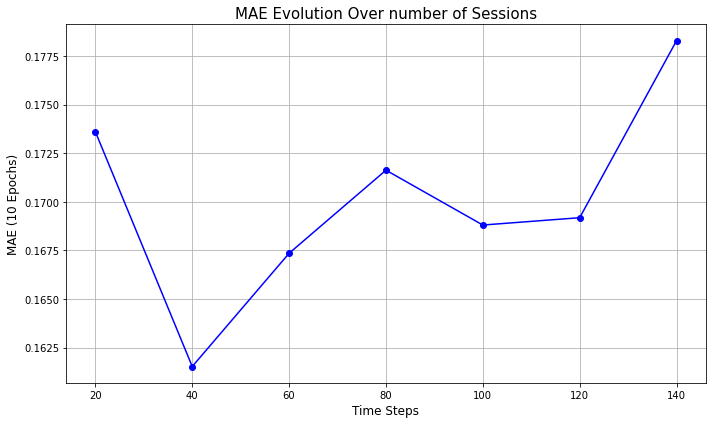

,time_steps,mae_10epochs
0,20,0.173602
1,40,0.161527
2,60,0.167351
3,80,0.171625
4,100,0.168804
5,120,0.169181
6,140,0.178286


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating a DataFrame from the provided data
data = {
    'time_steps': [20, 40, 60, 80, 100, 120, 140],
    'mae_10epochs': [0.173602, 0.161527, 0.167351, 0.171625, 0.168804, 0.169181, 0.178286]
}
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['time_steps'], df['mae_10epochs'], marker='o', color='b')
plt.title('MAE Evolution Over number of Sessions', fontsize=15)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('MAE (10 Epochs)', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot as an image
plot_filename = 'C:/Users/Alexander/Documents/GitHub/NNLangRecall/figs/mae_evolution_plot.png'
plt.savefig(plot_filename)

plt.show()

# Displaying the DataFrame as a table
df

